# Analysis on a Dataset
The dataset we will be looking at comes from the Airlines Industry. It has some basic information on the Airline routes. There is a Source of a journey and a destination. There are also a few columns indicating arrival and departure times for each journey. As you can imagine this dataset lends itself beautifully to be analysed as a Graph. Imagine a few cities (nodes) connected by airline routes (edges). If you are an airline carrier, you can then proceed to ask a few questions like
1. What is the shortest way to get from A to B? In terms of distance and in terms of time
2. Is there a way to go from C to D?
3. Which airports have the heaviest traffic?
4. Which airport in “in between” most other airports? So that it can be converted into a local hub

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pygraphviz as pgv
import matplotlib.pyplot as plt

data = pd.read_csv('/home/tangkun/analyticsvidhya/Airlines.csv')
data.shape
data.dtypes

(100, 16)

year                int64
month               int64
day                 int64
dep_time          float64
sched_dep_time      int64
dep_delay         float64
arr_time          float64
sched_arr_time      int64
arr_delay         float64
carrier            object
flight              int64
tailnum            object
origin             object
dest               object
air_time          float64
distance            int64
dtype: object

In [2]:
data

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance
0,2013,2,26,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946
1,2013,8,17,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076
2,2013,2,13,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402
3,2013,4,11,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626
4,2013,8,5,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2013,11,29,1129.0,1135,-6.0,1414.0,1436,-22.0,DL,1875,N342NB,LGA,TPA,147.0,1010
96,2013,3,10,1029.0,1029,0.0,1300.0,1344,-44.0,UA,1605,N37465,EWR,LAX,308.0,2454
97,2013,11,25,1724.0,1725,-1.0,1828.0,1845,-17.0,AA,256,N3CTAA,JFK,BOS,40.0,187
98,2013,3,5,930.0,929,1.0,1421.0,1426,-5.0,B6,215,N638JB,EWR,SJU,200.0,1608


We notice that the year, month, day and time information is spread over many columns. `We want to create one datetime column containing all of this information.` We also need to keep scheduled and actual time of arrival and departure separate. So we should finally have` 4 datetime columns (Scheduled and actual times of arrival and departure)`

In [3]:
# converting sched_dep_time to 'std' - Scheduled time of departure
data['std'] = data.sched_dep_time.astype(str).str.replace('(\d{2}$)', '') + ':' +\
data.sched_dep_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [4]:
# converting sched_arr_time to 'sta' - Scheduled time of arrival
data['sta'] = data.sched_arr_time.astype(str).str.replace('(\d{2}$)', '') + ':' + \
data.sched_arr_time.astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

# converting dep_time to 'atd' - Actual time of departure
data['atd'] = data.dep_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + \
':' + data.dep_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

In [5]:
# converting arr_time to 'ata' - Actual time of arrival
data['ata'] = data.arr_time.fillna(0).astype(np.int64).astype(str).str.replace('(\d{2}$)', '') + ':' + \
data.arr_time.fillna(0).astype(np.int64).astype(str).str.extract('(\d{2}$)', expand=False) + ':00'

We now have time columns in the format we wanted. Finally we may want to `combine the year, month and day columns into a date column`. This is not an absolutely necessary step. But we can easily obtain the year, month and day (and other) information once it is converted into datetime format.

In [6]:
data['date'] = pd.to_datetime(data[['year', 'month', 'day']])

In [7]:
# finally we drop the columns we don't need
data = data.drop(columns = ['year', 'month', 'day'])

In [8]:
data

,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,std,sta,atd,ata,date
0,1807.0,1630,97.0,1956.0,1837,79.0,EV,4411,N13566,EWR,MEM,144.0,946,16:30:00,18:37:00,18:07:00,19:56:00,2013-02-26
1,1459.0,1445,14.0,1801.0,1747,14.0,B6,1171,N661JB,LGA,FLL,147.0,1076,14:45:00,17:47:00,14:59:00,18:01:00,2013-08-17
2,1812.0,1815,-3.0,2055.0,2125,-30.0,AS,7,N403AS,EWR,SEA,315.0,2402,18:15:00,21:25:00,18:12:00,20:55:00,2013-02-13
3,2122.0,2115,7.0,2339.0,2353,-14.0,B6,97,N656JB,JFK,DEN,221.0,1626,21:15:00,23:53:00,21:22:00,23:39:00,2013-04-11
4,1832.0,1835,-3.0,2145.0,2155,-10.0,AA,269,N3EYAA,JFK,SEA,358.0,2422,18:35:00,21:55:00,18:32:00,21:45:00,2013-08-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1129.0,1135,-6.0,1414.0,1436,-22.0,DL,1875,N342NB,LGA,TPA,147.0,1010,11:35:00,14:36:00,11:29:00,14:14:00,2013-11-29
96,1029.0,1029,0.0,1300.0,1344,-44.0,UA,1605,N37465,EWR,LAX,308.0,2454,10:29:00,13:44:00,10:29:00,13:00:00,2013-03-10
97,1724.0,1725,-1.0,1828.0,1845,-17.0,AA,256,N3CTAA,JFK,BOS,40.0,187,17:25:00,18:45:00,17:24:00,18:28:00,2013-11-25
98,930.0,929,1.0,1421.0,1426,-5.0,B6,215,N638JB,EWR,SJU,200.0,1608,9:29:00,14:26:00,9:30:00,14:21:00,2013-03-05


In [9]:
#Now import the dataset using the networkx function that ingests a pandas dataframe directly. 
#Just like Graph creation there are multiple ways Data can be ingested into a Graph from multiple formats.
G = nx.from_pandas_edgelist(data, source='origin', target='dest', edge_attr=True,)

In [14]:
#对构建而成的网络进行分析
nx.connected_components(G)#得到当前图的每个连通分支的节点
nx.clustering(G)#得到当前图的每个节点的clustering
nx.average_clustering(G)#完成平均群聚系数的计算
nx.diameter(G)#返回图G的直径
nx.average_shortest_path_length(G)#返回图G所有节点间平均最短路径长度
nx.is_directed(G)#如果图是有向的，返回true
nx.density(G)#返回图的密度
nx.degree_centrality(G)#计算节点的度中心性
nx.closeness_centrality(G)#计算节点的接近中心性
nx.betweenness_centrality(G)#计算节点的介数中心性
nx.edge_betweenness_centrality(G)#计算边的介数中心性
nx.eigenvector_centrality(G)#计算节点的特征向量中心性
nx.current_flow_betweenness_centrality(G)#计算节点的流介数中心性
nx.edge_current_flow_betweenness_centrality(G)#计算边的流介数中心性
G.number_of_nodes()#'图中的节点个数'
G.number_of_edges()#'图中的边数',

<generator object connected_components at 0x7ff3377f7550>

{'EWR': 0,
 'MEM': 0,
 'LGA': 0,
 'FLL': 0,
 'SEA': 0,
 'JFK': 0,
 'DEN': 0,
 'ORD': 0,
 'MIA': 0,
 'PBI': 0,
 'MCO': 0,
 'CMH': 0,
 'MSP': 0,
 'IAD': 0,
 'CLT': 0,
 'TPA': 0,
 'DCA': 0,
 'SJU': 0,
 'ATL': 0,
 'BHM': 0,
 'SRQ': 0,
 'MSY': 0,
 'DTW': 0,
 'LAX': 0,
 'JAX': 0,
 'RDU': 0,
 'MDW': 0,
 'DFW': 0,
 'IAH': 0,
 'SFO': 0,
 'STL': 0,
 'CVG': 0,
 'IND': 0,
 'RSW': 0,
 'BOS': 0,
 'CLE': 0}

0.0

{'EWR': 0,
 'MEM': 0,
 'LGA': 0,
 'FLL': 0,
 'SEA': 0,
 'JFK': 0,
 'DEN': 0,
 'ORD': 0,
 'MIA': 0,
 'PBI': 0,
 'MCO': 0,
 'CMH': 0,
 'MSP': 0,
 'IAD': 0,
 'CLT': 0,
 'TPA': 0,
 'DCA': 0,
 'SJU': 0,
 'ATL': 0,
 'BHM': 0,
 'SRQ': 0,
 'MSY': 0,
 'DTW': 0,
 'LAX': 0,
 'JAX': 0,
 'RDU': 0,
 'MDW': 0,
 'DFW': 0,
 'IAH': 0,
 'SFO': 0,
 'STL': 0,
 'CVG': 0,
 'IND': 0,
 'RSW': 0,
 'BOS': 0,
 'CLE': 0}

4

2.36984126984127

False

0.09047619047619047

{'EWR': 0.5714285714285714,
 'MEM': 0.02857142857142857,
 'LGA': 0.5714285714285714,
 'FLL': 0.05714285714285714,
 'SEA': 0.05714285714285714,
 'JFK': 0.4857142857142857,
 'DEN': 0.05714285714285714,
 'ORD': 0.05714285714285714,
 'MIA': 0.05714285714285714,
 'PBI': 0.08571428571428572,
 'MCO': 0.08571428571428572,
 'CMH': 0.02857142857142857,
 'MSP': 0.05714285714285714,
 'IAD': 0.08571428571428572,
 'CLT': 0.05714285714285714,
 'TPA': 0.08571428571428572,
 'DCA': 0.05714285714285714,
 'SJU': 0.05714285714285714,
 'ATL': 0.05714285714285714,
 'BHM': 0.02857142857142857,
 'SRQ': 0.02857142857142857,
 'MSY': 0.02857142857142857,
 'DTW': 0.05714285714285714,
 'LAX': 0.05714285714285714,
 'JAX': 0.02857142857142857,
 'RDU': 0.05714285714285714,
 'MDW': 0.02857142857142857,
 'DFW': 0.02857142857142857,
 'IAH': 0.05714285714285714,
 'SFO': 0.02857142857142857,
 'STL': 0.02857142857142857,
 'CVG': 0.05714285714285714,
 'IND': 0.02857142857142857,
 'RSW': 0.02857142857142857,
 'BOS': 0.0571428

{'EWR': 0.5555555555555556,
 'MEM': 0.36082474226804123,
 'LGA': 0.5555555555555556,
 'FLL': 0.43209876543209874,
 'SEA': 0.45454545454545453,
 'JFK': 0.5072463768115942,
 'DEN': 0.43209876543209874,
 'ORD': 0.4666666666666667,
 'MIA': 0.4666666666666667,
 'PBI': 0.5223880597014925,
 'MCO': 0.5223880597014925,
 'CMH': 0.36082474226804123,
 'MSP': 0.4666666666666667,
 'IAD': 0.5223880597014925,
 'CLT': 0.43209876543209874,
 'TPA': 0.5223880597014925,
 'DCA': 0.43209876543209874,
 'SJU': 0.45454545454545453,
 'ATL': 0.43209876543209874,
 'BHM': 0.36082474226804123,
 'SRQ': 0.33980582524271846,
 'MSY': 0.36082474226804123,
 'DTW': 0.43209876543209874,
 'LAX': 0.45454545454545453,
 'JAX': 0.33980582524271846,
 'RDU': 0.4666666666666667,
 'MDW': 0.36082474226804123,
 'DFW': 0.36082474226804123,
 'IAH': 0.4666666666666667,
 'SFO': 0.36082474226804123,
 'STL': 0.36082474226804123,
 'CVG': 0.4666666666666667,
 'IND': 0.36082474226804123,
 'RSW': 0.36082474226804123,
 'BOS': 0.45454545454545453

{'EWR': 0.44733893557422966,
 'MEM': 0.0,
 'LGA': 0.40952380952380946,
 'FLL': 0.007282913165266107,
 'SEA': 0.01204481792717087,
 'JFK': 0.30952380952380965,
 'DEN': 0.007282913165266107,
 'ORD': 0.011484593837535018,
 'MIA': 0.011484593837535018,
 'PBI': 0.030812324929971994,
 'MCO': 0.030812324929971994,
 'CMH': 0.0,
 'MSP': 0.011484593837535018,
 'IAD': 0.030812324929971994,
 'CLT': 0.007282913165266107,
 'TPA': 0.030812324929971994,
 'DCA': 0.007282913165266107,
 'SJU': 0.01204481792717087,
 'ATL': 0.007282913165266107,
 'BHM': 0.0,
 'SRQ': 0.0,
 'MSY': 0.0,
 'DTW': 0.007282913165266107,
 'LAX': 0.01204481792717087,
 'JAX': 0.0,
 'RDU': 0.011484593837535018,
 'MDW': 0.0,
 'DFW': 0.0,
 'IAH': 0.011484593837535018,
 'SFO': 0.0,
 'STL': 0.0,
 'CVG': 0.011484593837535018,
 'IND': 0.0,
 'RSW': 0.0,
 'BOS': 0.01204481792717087,
 'CLE': 0.0}

{('EWR', 'MEM'): 0.05555555555555555,
 ('EWR', 'SEA'): 0.04153439153439154,
 ('EWR', 'MIA'): 0.03827160493827161,
 ('EWR', 'ORD'): 0.0382716049382716,
 ('EWR', 'MSP'): 0.03827160493827161,
 ('EWR', 'TPA'): 0.04285714285714285,
 ('EWR', 'MSY'): 0.05555555555555555,
 ('EWR', 'DFW'): 0.05555555555555555,
 ('EWR', 'IAH'): 0.03827160493827161,
 ('EWR', 'SFO'): 0.05555555555555555,
 ('EWR', 'CVG'): 0.03827160493827161,
 ('EWR', 'IND'): 0.05555555555555555,
 ('EWR', 'RDU'): 0.03827160493827161,
 ('EWR', 'IAD'): 0.04285714285714285,
 ('EWR', 'RSW'): 0.05555555555555555,
 ('EWR', 'BOS'): 0.04153439153439153,
 ('EWR', 'PBI'): 0.042857142857142844,
 ('EWR', 'LAX'): 0.04153439153439155,
 ('EWR', 'MCO'): 0.042857142857142844,
 ('EWR', 'SJU'): 0.04153439153439155,
 ('LGA', 'FLL'): 0.03765432098765434,
 ('LGA', 'ORD'): 0.03897707231040565,
 ('LGA', 'PBI'): 0.036772486772486776,
 ('LGA', 'CMH'): 0.05555555555555555,
 ('LGA', 'IAD'): 0.03677248677248678,
 ('LGA', 'CLT'): 0.03765432098765434,
 ('LGA', '

{'EWR': 0.41270371965737646,
 'MEM': 0.06711591581231252,
 'LGA': 0.4392922830543092,
 'FLL': 0.1315672823889629,
 'SEA': 0.12724331900684804,
 'JFK': 0.3697305275838997,
 'DEN': 0.1315672823889629,
 'ORD': 0.13855579500673987,
 'MIA': 0.13855579500673987,
 'PBI': 0.19868319820127542,
 'MCO': 0.19868319820127542,
 'CMH': 0.07143987919442736,
 'MSP': 0.13855579500673987,
 'IAD': 0.19868319820127542,
 'CLT': 0.1315672823889629,
 'TPA': 0.19868319820127542,
 'DCA': 0.1315672823889629,
 'SJU': 0.12724331900684804,
 'ATL': 0.1315672823889629,
 'BHM': 0.07143987919442736,
 'SRQ': 0.06012740319453555,
 'MSY': 0.06711591581231252,
 'DTW': 0.1315672823889629,
 'LAX': 0.12724331900684804,
 'JAX': 0.06012740319453555,
 'RDU': 0.13855579500673987,
 'MDW': 0.07143987919442736,
 'DFW': 0.06711591581231252,
 'IAH': 0.13855579500673987,
 'SFO': 0.06711591581231252,
 'STL': 0.07143987919442736,
 'CVG': 0.13855579500673987,
 'IND': 0.06711591581231252,
 'RSW': 0.06711591581231252,
 'BOS': 0.127243319006

{'EWR': 0.5641652465181882,
 'MEM': 0.0,
 'LGA': 0.5311218193571121,
 'FLL': 0.025885878827055328,
 'SEA': 0.03269671504965621,
 'JFK': 0.4515660809778456,
 'DEN': 0.025885878827055318,
 'ORD': 0.03006405359346531,
 'MIA': 0.030064053593465315,
 'PBI': 0.049503437738731816,
 'MCO': 0.04950343773873191,
 'CMH': -1.791284207798572e-17,
 'MSP': 0.030064053593465315,
 'IAD': 0.04950343773873185,
 'CLT': 0.025885878827055283,
 'TPA': 0.049503437738731795,
 'DCA': 0.025885878827055283,
 'SJU': 0.03269671504965613,
 'ATL': 0.025885878827055318,
 'BHM': -3.7318420995803583e-19,
 'SRQ': 0.0,
 'MSY': 0.0,
 'DTW': 0.025885878827055415,
 'LAX': 0.032696715049656225,
 'JAX': 0.0,
 'RDU': 0.030064053593465315,
 'MDW': -1.8659210497901792e-19,
 'DFW': 0.0,
 'IAH': 0.030064053593465315,
 'SFO': 0.0,
 'STL': -7.463684199160717e-19,
 'CVG': 0.0300640535934653,
 'IND': 0.0,
 'RSW': 0.0,
 'BOS': 0.03269671504965624,
 'CLE': 4.7767578874628587e-17}

{('MEM', 'EWR'): 0.029411764705882353,
 ('EWR', 'SEA'): 0.03116883116883116,
 ('MIA', 'EWR'): 0.029726156196744388,
 ('ORD', 'EWR'): 0.029726156196744385,
 ('MSP', 'EWR'): 0.029726156196744388,
 ('EWR', 'TPA'): 0.0285185402832462,
 ('MSY', 'EWR'): 0.029411764705882353,
 ('DFW', 'EWR'): 0.029411764705882353,
 ('IAH', 'EWR'): 0.029726156196744388,
 ('SFO', 'EWR'): 0.029411764705882353,
 ('CVG', 'EWR'): 0.029726156196744388,
 ('IND', 'EWR'): 0.029411764705882353,
 ('RDU', 'EWR'): 0.029726156196744388,
 ('EWR', 'IAD'): 0.028518540283246185,
 ('RSW', 'EWR'): 0.029411764705882353,
 ('EWR', 'BOS'): 0.031168831168831183,
 ('EWR', 'PBI'): 0.02851854028324615,
 ('EWR', 'LAX'): 0.03116883116883116,
 ('EWR', 'MCO'): 0.02851854028324612,
 ('EWR', 'SJU'): 0.031168831168831124,
 ('LGA', 'FLL'): 0.027775166010460133,
 ('ORD', 'LGA'): 0.029749662102603235,
 ('LGA', 'PBI'): 0.0244343891402715,
 ('CMH', 'LGA'): 0.02941176470588237,
 ('LGA', 'IAD'): 0.02443438914027147,
 ('LGA', 'CLT'): 0.0277751660104601

36

57

In [23]:
nx.diameter(G)#返回图G的直径
nx.average_shortest_path_length(G)#返回图G所有节点间平均最短路径长度
nx.is_directed(G)#如果图是有向的，返回true
nx.density(G)#返回图的密度
G.number_of_edges()#'图中的边数',
G.number_of_nodes()#'图中的节点个数
nx.average_degree_connectivity(G) # For a node of degree k - What is the average of its neighbours' degree?

4

2.36984126984127

False

0.09047619047619047

57

36

{20: 1.95, 1: 19.307692307692307, 2: 19.0625, 17: 2.0588235294117645, 3: 19.0}

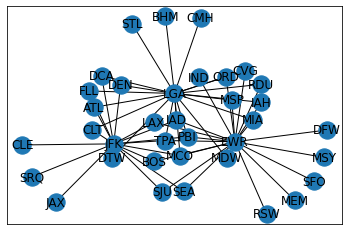

In [15]:
nx.draw_networkx(G, with_labels=True) # Quick view of the Graph. As expected we see 3 very busy airports

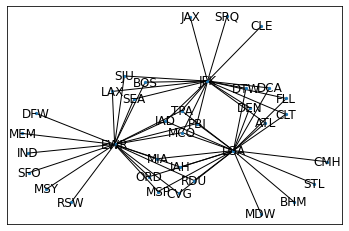

In [48]:
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, with_labels = True, node_size = 5)

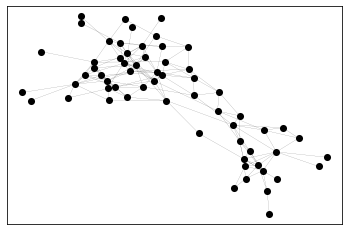

In [78]:
import urllib.request as urllib
import io
import zipfile

url = "http://www-personal.umich.edu/~mejn/netdata/dolphins.zip"

sock = urllib.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("dolphins.txt").decode()  # read info file
gml = zf.read("dolphins.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

# print(txt)
# print degree for each dolphin
# for n, d in G.degree():
#     print(f"{n:20} {d:2}")
#print nodes and edges for each dolphin
# G.nodes()
# G.edges()
options = {
    "node_color": "black",
    "node_size": 50,
    "linewidths": 0,
    "width": 0.1,
    'with_labels': False
}

# pos = nx.spring_layout(G, seed=1969)  # Seed for reproducible layout
# nx.draw(G, pos, **options)
nx.draw_networkx(G, **options)
plt.show()

In [81]:
nx.average_clustering(G)

0.2589582460550202

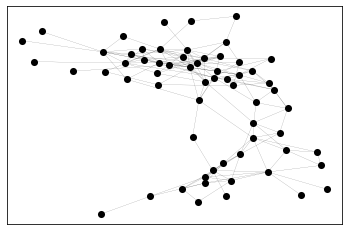

In [92]:
nx.draw_networkx(G, pos, **options)